# Result
Here are some of the result on the dataset

training: 2014,2015,2016 regular season

dev: 0.1 of the training set

test: 2017 regular season

In [1]:
import pandas as pd
import numpy as np
import math
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [2]:
base_dir = "Data/"

label2one = {'B':0,'S':1,'X':2}
one2label = {0:'B', 1:'S', 2:'X'}

def normalize(data):
    mu = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return mu, std, (data-mu)/std

vfunc = np.vectorize(lambda x:label2one[x])

input_labels = ['pitcher','batter', 'pitch_type','x0','x','y','ax','ay','az','px','pz','sz_top','sz_bot',
             'vx0','vy0','vz0','pfx_x','z0','start_speed','end_speed',
             'break_y','break_angle','break_length','spin_dir','spin_rate',
             'inning','balls','strikes'
             ]
#input_labels = ['pitcher','batter', 'pitch_type','balls', 'strikes','inning','pitch_count']
#input_labels = ['pitcher','batter', 
       #'on_1b', 'on_2b', 'on_3b', 'pitch_type', 'side', 
       #'inning', 'pitch_count', 'balls', 'strikes','offense_score', 'defense_score', 
#       'ay', 'px', 'ax',  
#       'sz_bot', 'vz0', 'vy0', 'pfx_x',
#       'type_confidence', 'z0', 'tfs', 'pz', 'start_speed', 'az', 'zone',
#       'break_angle', 'spin_dir', 'end_speed', 'vx0', 'sz_top', 'nasty',
#       'pfx_z', 'break_y', 'x', 'spin_rate',
#       'y0', 'break_length', 'y', 'x0'
#       ]
feature_length = len(input_labels)-3
print("Feature length:{}".format(feature_length))
train_years = [4,5,6]
dev_years = [7]


train_x = {}
train_y = {}
ctr = 0
for y in train_years:
    filename= base_dir+"MLB_201{0}/MLB_PitchFX_201{0}_RegularSeason.csv".format(str(y))
    print("Loading {}".format(filename))
    f = pd.read_csv(filename)
    
    tmp_x = f[input_labels]
    tmp_y = f['umpcall']

    tmp_x = tmp_x.as_matrix()
    tmp_y = tmp_y.as_matrix()
    tmp_y = vfunc(tmp_y)

    if ctr==0:
        ctr=1
        train_x = tmp_x
        train_y = tmp_y
    else:
        print(train_x.shape)
        print(tmp_x.shape)
        train_x = np.concatenate((train_x, tmp_x), axis=0)
        train_y = np.concatenate((train_y, tmp_y), axis=0)
    
    filename= base_dir+"MLB_201{0}/MLB_PitchFX_201{0}_PostSeason.csv".format(str(y))
    print("Loading {}".format(filename))
    f = pd.read_csv(filename)
    
    tmp_x = f[input_labels]
    tmp_y = f['umpcall']

    tmp_x = tmp_x.as_matrix()
    tmp_y = tmp_y.as_matrix()
    tmp_y = vfunc(tmp_y)
    if ctr==0:
        ctr=1
        train_x = tmp_x
        train_y = tmp_y
    else:
        print(train_x.shape)
        print(tmp_x.shape)
        train_x = np.concatenate((train_x, tmp_x), axis=0)
        train_y = np.concatenate((train_y, tmp_y), axis=0)

filename = base_dir+"MLB_2017/MLB_PitchFX_2017_RegularSeason.csv"
print("Loading test file {}".format(filename))
f2 = pd.read_csv(filename)
test_x = f2[input_labels]
test_y = f2['umpcall']

test_x = test_x.as_matrix()
test_y = test_y.as_matrix()
test_y = vfunc(test_y)

filename = base_dir+"MLB_2017/MLB_PitchFX_2017_PostSeason.csv"
print("Loading test file {}".format(filename))
f2 = pd.read_csv(filename)

tmp_x = f2[input_labels]
tmp_y = f2['umpcall']

tmp_x = tmp_x.as_matrix()
tmp_y = tmp_y.as_matrix()
tmp_y = vfunc(tmp_y)

test_x = np.concatenate((test_x, tmp_x), axis=0)
test_y = np.concatenate((test_y, tmp_y), axis=0)

Feature length:25
Loading Data/MLB_2014/MLB_PitchFX_2014_RegularSeason.csv
Loading Data/MLB_2014/MLB_PitchFX_2014_PostSeason.csv
(658428, 28)
(8837, 28)
Loading Data/MLB_2015/MLB_PitchFX_2015_RegularSeason.csv
(667265, 28)
(672271, 28)
Loading Data/MLB_2015/MLB_PitchFX_2015_PostSeason.csv
(1339536, 28)
(10277, 28)
Loading Data/MLB_2016/MLB_PitchFX_2016_RegularSeason.csv
(1349813, 28)
(703809, 28)
Loading Data/MLB_2016/MLB_PitchFX_2016_PostSeason.csv
(2053622, 28)
(10076, 28)
Loading test file Data/MLB_2017/MLB_PitchFX_2017_RegularSeason.csv
Loading test file Data/MLB_2017/MLB_PitchFX_2017_PostSeason.csv


In [3]:
vv = np.vectorize(lambda x: (isinstance(x, float) and math.isnan(x) ))
idx = ~np.logical_or(vv(train_x[:,0]), vv(train_x[:,1]))
train_x = train_x[idx]
train_y = train_y[idx]

In [4]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import pickle
import seaborn as sn
import matplotlib.pyplot as plt

def generate_confusion_matrix(y_test, y_train, file_name = "confusion_matrix.png"):
    ax= plt.subplot()
    cm = confusion_matrix(y_test, y_train)
    df_cm = pd.DataFrame(cm, range(3), range(3))
    sn.set(font_scale=1.2)#for label size
    sn.heatmap(df_cm, annot=True, fmt="d",annot_kws={"size": 14}, cmap="YlGnBu")
#     ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['Ball', 'Strike', 'Hit']) 
    ax.yaxis.set_ticklabels(['Ball', 'Strike', 'Hit'])
    #plt.savefig(file_name)
    plt.show()

In [5]:
from sklearn.model_selection import train_test_split
train_x, dev_x, train_y, dev_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0, shuffle=True)

In [6]:
def criterion(pred, y):
    s = 0;
    for i in range(pred.shape[0]):
        s -= np.log(pred[i,y[i]])
    return s/y.shape[0]

In [7]:
def accuracy(pred, y):
    s = np.sum(pred==y)
    return s/y.shape[0]

## Baseline
We can simply predict the output to be all 1 as the 'S' is the most outcome in our training data. The accuracy of this simple prediction function is:

The accuracy on the test set is: 0.47999643589058183

The cross-entropy on the test set is: 1.0986122886679723

The confusion matrix is:
```text
array([[   0, 4009,    0],
       [   0, 5387,    0],
       [   0, 1827,    0]])
```

In [8]:
prob_y = np.zeros((1,3))
for i in test_y:
    prob_y[0,i] +=1
prob_y = prob_y/np.sum(prob_y)
prob_y = np.repeat(prob_y, test_y.shape[0], axis=0)
pred_y = np.argmax(prob_y, 1)


In [9]:
criterion(prob_y, test_y)

1.031404418480492

In [10]:
accuracy(pred_y, test_y)

0.45906764268809513

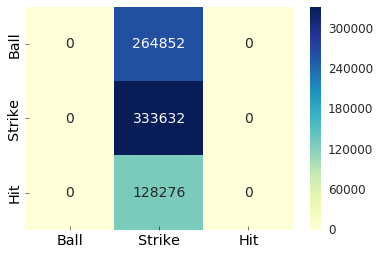

In [11]:
generate_confusion_matrix(test_y, pred_y)

# Baseline 2
We explore the effect of combining strike, balls as single categorical variable.

In [12]:
cum_ctrs = {}
for i in range(train_y.shape[0]):
    b = str(train_x[i, -2])
    s = str(train_x[i, -1])
    lab = b + ' ' + s
    if lab not in cum_ctrs:
        cum_ctrs[lab] = [0,0,0]
    else:
        cum_ctrs[lab][train_y[i]] += 1

In [13]:
prob_y = np.zeros((test_y.shape[0], 3))
for i in range(test_y.shape[0]):
    b = str(test_x[i, -2])
    s = str(test_x[i, -1])
    lab = b + ' ' + s
    prob_y[i,:] = cum_ctrs[lab] / np.sum(cum_ctrs[lab])
pred_y = np.argmax(prob_y, 1)

In [14]:
criterion(prob_y, test_y)

1.0159492954611336

In [15]:
accuracy(pred_y, test_y)

0.46632863668886565

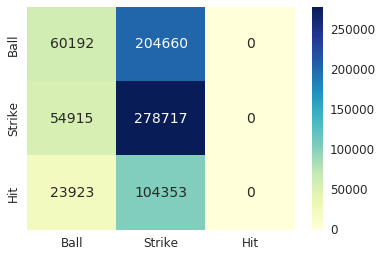

In [16]:
generate_confusion_matrix(test_y, pred_y)

# Recurrent Neural Network
```text
LSTM(
  (embedding): PlayerEmbedding(
    (emb_mon): Embedding(13, 100)
    (emb_day): Embedding(32, 100)
    (emb_player): Embedding(1880, 256)
    (emb_stadium): Embedding(34, 10)
  )
  (lstm): LSTM(1490, 1024, num_layers=2, dropout=0.1)
  (lin1): Linear(in_features=1024, out_features=1024, bias=True)
  (lin2): Linear(in_features=1024, out_features=3, bias=True)
)```

In [ ]:
1.0353, 0.4543989762782762

# Shallow NN w/ Post + Avg. Gen.
In this model, we first train our shallow Net with data including the post pitch features. And use a generative model to make the prediction.

We use all of the following features as our input:
``` text
'pitcher','batter', 'pitch_type','x0','x','y','ax','ay','az','px','pz','sz_top','sz_bot',
 'vx0','vy0','vz0','pfx_x','z0','start_speed','end_speed',
 'break_y','break_angle','break_length','spin_dir','spin_rate',
 'inning','balls','strikes'```

This is the structure of the shallow NN:
```text
Fcc(
  (embedding): PlayerEmbedding(
    (embedding1): Embedding(1120, 100)
    (embedding2): Embedding(1445, 100)
  )
  (drop1): Dropout(p=0.1)
  (lin1): Linear(in_features=225, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=50, bias=True)
  (lin4): Linear(in_features=50, out_features=3, bias=True)
)```
After 30 epoch of training:

The accuracy on the test set is: 0.7106440969731745

The cross-entropy on the test set is: 0.6153840772368059

The confusion matrix is:
```text
array([[3276,  721,   12],
       [ 658, 4446,  283],
       [  92, 1446,  289]])
```

One observation is that the 'X'(2) classes is likely to be predicted as 'S'(1). This coincide to our knowledge of the baseball.

## The Generation Model
Since we do not have most of the pitch/fx features. We average the feature from the training data grouped by pitcher,batter and pitch_type

The accuracy on the test set is: 0.450325224984407

The cross-entropy on the test set is: 1.7214855619830554

The confusion matrix is:
```text
array([[  99, 3454,  456],
       [ 124, 4656,  607],
       [  30, 1498,  299]])
```

From the confusion matrix, we can see that most of the prediction is 'S'. This might be dut to we are averaging dataset to generate input and most entries in the dataset are 'S'.

# Shallow NN w/o Post Features
We use the same structure as the previous model but with only the input features:
```text
'pitcher','batter','balls', 'strikes','inning','pitch_count'
```

The accuracy on the test set is: 0.47042509443886577

The cross-entropy on the test set is: 0.9997494564191931

The confusion matrix is:
```text
array([[ 928, 3066,   15],
       [ 866, 4489,   32],
       [ 326, 1485,   16]])
```

# Deep Model w/ Post + Avg. Gen
We follow the same procedure in the shallow model.

We use all of the following features as our input:
``` text
'pitcher','batter', 'pitch_type','x0','x','y','ax','ay','az','px','pz','sz_top','sz_bot',
 'vx0','vy0','vz0','pfx_x','z0','start_speed','end_speed',
 'break_y','break_angle','break_length','spin_dir','spin_rate',
 'inning','balls','strikes'```

```text
Fcc(
  (embedding): PlayerEmbedding(
    (embedding1): Embedding(1120, 100)
    (embedding2): Embedding(1445, 100)
    (conv1): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (maxpol): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True)
  (fea1): Linear(in_features=25, out_features=64, bias=True)
  (feares2): ResNet(
    (lin1): Linear(in_features=64, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=64, bias=True)
  )
  (fea3): Linear(in_features=64, out_features=64, bias=True)
  (lin1): Linear(in_features=1664, out_features=1024, bias=True)
  (res2): ResNet(
    (lin1): Linear(in_features=1024, out_features=1024, bias=True)
    (lin2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (res3): ResNet(
    (lin1): Linear(in_features=1024, out_features=1024, bias=True)
    (lin2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (lin3): Linear(in_features=1024, out_features=256, bias=True)
  (res4): ResNet(
    (lin1): Linear(in_features=256, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
  )
  (res5): ResNet(
    (lin1): Linear(in_features=256, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
  )
  (lin8): Linear(in_features=256, out_features=3, bias=True)
)```

After 10 epoch of training,

The accuracy on the test set is: 0.743473224627996

The cross-entropy on the test set is: 0.6006864595759783

The confusion matrix is:
```text
array([[3404,  598,    7],
       [ 453, 4488,  446],
       [  44, 1331,  452]])
```

## The Generation Model
Since we do not have most of the pitch/fx features. We average the feature from the training data grouped by pitcher,batter and pitch_type

The accuracy on the test set is: 0.4631560188897799 <- 0.450325224984407

The cross-entropy on the test set is: 1.7626901821693999 <- 1.7214855619830554

The confusion matrix is:
```text
array([[ 130, 3624,  255],
       [ 166, 4894,  327],
       [  51, 1602,  174]])
```

# Deep NN w/o Post Features
We use the same structure as the previous model but with only the input features:
```text
'pitcher','batter','balls', 'strikes','inning','pitch_count'
```

After 5 epoch,

The accuracy on the test set is: 0.48730286019780805

The cross-entropy on the test set is: 0.9971903735363663

The confusion matrix is:
```text
array([[ 846, 3163,    0],
       [ 764, 4623,    0],
       [ 290, 1537,    0]])
```

Interesting, the model never predict the outcome as 'X'.

# Comparison between Deep and Shallow NN
One of the observation is that the embedding layer of shallow NN is more likely to diverge, that is, the loss of validation set goes up without ever converging.